## Imports

In [16]:
import numpy as np
from numpy.typing import NDArray
import math
import pandas as pd
import matplotlib.pyplot as plt

## Psuedo Code
Pseudo code found in this [article](https://int8.io/monte-carlo-tree-search-beginners-guide/) that was linked to in the assingment.
```python
def monte_carlo_tree_search(root):
    while resources_left(time, computational_power):
        leaf = traverse(root)  # leaf = unvisited node
        simulation_result = rollout(leaf)
        backpropagate(leaf, simulation_result)
    return best_child(root)

def traverse(node):
    while fully_expanded(node):
        node = best_uct(node)
    return pick_unvisited(node.children) or node  # in case no children are present or node is terminal

def rollout(node):
    while not is_terminal(node):
        node = rollout_policy(node)
    return result(node)

def rollout_policy(node):
    return pick_random(node.children)

def backpropagate(node, result):
    if node is None:
        return
    node.visits += 1
    node.total_reward += result
    backpropagate(node.parent, result)

def best_child(node):
    # pick child with highest number of visits
    return max(node.children, key=lambda c: c.visits)
```

## Python implementation
Here we make our own implementation of monte carlo tree search based on the pseudocode supplied above, we wrap it in a class that we call BetaTicTacToe which is intended as the actual program that you play against.

In [11]:
class Node:
    def __init__(self, state, terminal, parent, team):
        self.state: NDArray = state
        self.legal_actions: list[tuple] = [tuple(l) for l in np.argwhere(state == 0)]
        self.performed_actions: list[tuple] = []
        self.parent: Node = parent
        self.team: int = team
        self.children: list[Node] = []
        self.q: float = 0.0
        self.visits: int = 0
        self.terminal: bool = terminal

    def possible_actions(self):
        return [a for a in self.legal_actions if a not in self.performed_actions]

    def is_fully_expanded(self):
        if len(self.legal_actions) == len(self.performed_actions):
            return True

    def is_terminal(self):
        return self.terminal


class MonteCarloTreeSearch:

    def __init__(self, exploration_scale=1.0, search_iterations=1000):
        self.rng = np.random.default_rng()
        self.exploration_scale = exploration_scale
        self.search_iterations = search_iterations

    def search(self, root: Node):
        for _ in range(self.search_iterations):
            node = self.traverse(root)
            simulation_result = self.rollout(node)
            # Fix the persepctive.
            if node.parent:
                simulation_result *= node.parent.team
            self.backpropagate(node, simulation_result)

    def traverse(self, node: Node):
        # Go down the tree until a node that is terminal or not fully
        # expanded is found
        while node.is_fully_expanded() and not node.is_terminal():
            node = self.best_uct(node)
        # I the node is terminal return it, otherwise if its expanded
        # just return one of its children, if not expand it and return one
        # of its children
        if not node.is_terminal():
            return self.expand(node)
        return node

    def backpropagate(self, node: Node, result: float):
        # Add the results from a node to its parents. This includes:
        # visits: it's required to visit a parent node to reach any terminal
        # node.
        # q score: If the node has a state that is a win, draw, or loss for
        # the current player it's added to the parent node.
        if node is None:
            return
        node.visits += 1
        node.q += result
        # Flip the sign of the result, a win for me is a loss for my parent
        if node.parent:
            self.backpropagate(node.parent, -result)

    def rollout_policy(self, state: NDArray):
        # Get all legal actions
        legal_actions = np.argwhere(state == 0)
        idx = self.rng.integers(len(legal_actions))
        return tuple(legal_actions[idx])

    def rollout(self, node: Node):
        # Perform a rollout, which means moving from a node to the end
        # by sampling random actions (moves)
        state = node.state.copy()
        team = node.team
        while not self.state_is_terminal(state):
            # Query the policy for the next action.
            action = self.rollout_policy(state)
            # Make next move.
            state[action] = team
            # Switch to next player.
            team = -team
        return self.state_result(state)

    def state_is_terminal(self, state: NDArray):
        # If the results is a win
        if self.state_result(state) != 0:
            return True
        # Or if all spaces are filled
        return not np.any(state == 0)

    def state_result(self, state: NDArray):
        side_size = state.shape[0]
        diag = np.diag(state)
        anti_diag = np.diag(np.fliplr(state))

        # Check rows and columns
        for i in range(side_size):
            if np.all(state[i, :] == 1) or np.all(state[:, i] == 1):
                return 1
            if np.all(state[i, :] == -1) or np.all(state[:, i] == -1):
                return -1

        # Check diagonals
        if np.all(diag == 1) or np.all(anti_diag == 1):
            return 1
        if np.all(diag == -1) or np.all(anti_diag == -1):
            return -1

        return 0

    def best_uct(self, node: Node):
        if node.children:
            return max(node.children, key=lambda c: self.uct(node, c))
        return node

    def uct(self, parent: Node, child: Node):
        exploitation = child.q / child.visits
        exploration = self.exploration_scale * math.sqrt(
            math.log(parent.visits) / child.visits
        )
        return exploitation + exploration

    def expand_policy(self, actions: tuple):
        idx = self.rng.integers(len(actions))
        return actions[idx]

    def expand(self, node: Node):
        possible_actions = node.possible_actions()
        chosen_action = self.expand_policy(possible_actions)
        new_state = node.state.copy()
        new_state[chosen_action] = node.team
        new_state_terminal = self.state_is_terminal(new_state)
        node.performed_actions.append(chosen_action)
        child = Node(new_state, new_state_terminal, node, -node.team)
        node.children.append(child)
        return child


class BetaTicTacToe:

    def __init__(self, exploration_scale=1.0, search_iterations=1000):
        self.mcts = MonteCarloTreeSearch(exploration_scale, search_iterations)

    def play(self, root):
        """
        Returns the next game state (indlucing AI move) given a current game state.
        """
        # Conduct a search
        self.mcts.search(root)
        # find the next best move/state
        if root.children:
            return max(root.children, key=lambda c: c.visits)
        return root


# Small test example
bttt = BetaTicTacToe()
initial_board = np.zeros((3, 3), dtype=np.int8)
root = Node(initial_board, False, None, 1)
next = bttt.play(root)
display("First move played by BetaTicTacToe", next.state)

'First move played by BetaTicTacToe'

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]], dtype=int8)

# Interactive game loop

In [12]:
play_game = None
while play_game not in ["yes", "no"]:
    play_game = input(
        "Do you wish to play Tic-Tac-Toe against BetaTicTacToe? (yes/no): "
    ).lower()

if play_game == "yes":
    bttt = BetaTicTacToe()

    # 1. Select side (1 starts, -1 goes second)
    user_side = 0
    while user_side not in [1, -1]:
        try:
            user_side = int(
                input(
                    "Choose your side. Enter 1 to go first (X), or -1 to go second (O): "
                )
            )
        except ValueError:
            continue

    # 2. Create start state - 1 always starts first
    initial_state = np.zeros((3, 3), dtype=np.int8)
    current_node = Node(initial_state, False, 0, None, 1)

    # 3. Run game loop
    while not bttt.mcts.state_is_terminal(current_node.state):
        print("Board state:")
        print(current_node.state)

        # Determine if it is the Human's turn
        is_human_turn = current_node.team == user_side

        if is_human_turn:
            print("--- Your Turn ---")
            move_made = False
            while not move_made:
                try:
                    row = int(input("Enter row (0-2): "))
                    col = int(input("Enter col (0-2): "))
                    if current_node.state[row, col] == 0:
                        # Deterministically create the exact game state
                        new_state = current_node.state.copy()
                        new_state[row, col] = current_node.team

                        is_term = bttt.mcts.state_is_terminal(new_state)
                        res = bttt.mcts.state_result(new_state)

                        # Assign the human move as the new root node
                        current_node = Node(
                            new_state, is_term, res, None, -current_node.team
                        )
                        move_made = True
                    else:
                        print("Spot already taken!")
                except (ValueError, IndexError):
                    print("Invalid input. Use 0, 1, or 2.")
        else:
            print("--- BetaTicTacToe Turn ---")
            current_node = bttt.play(current_node)
            # Reset parent to save memory and keep current_node as the new root
            current_node.parent = None

    # Final Result
    print("Final Board:")
    print(current_node.state)
    res = bttt.mcts.state_result(current_node.state)

    if res == 0:
        print("It's a draw!")
    elif (res == 1 and user_side == 1) or (res == -1 and user_side == -1):
        print("Human wins!")
    else:
        print("BetaTicTacToe wins!")

# Comparison of exploration scales.

In [ ]:
exp_scales = [-128.0, -64.0, -32.0, -16.0, -8.0, -4.0, 0.0, 1.0, 8.0, 16.0]
rng = np.random.default_rng()
nr_of_games = range(20)
scores = {}
judge = BetaTicTacToe()
switch = lambda p: 0 if p == 1 else 1

for es in exp_scales:
    bttt1_wins = 0
    bttt2_wins = 0
    draws = 0
    bttt1 = BetaTicTacToe()
    bttt2 = BetaTicTacToe(exploration_scale=es)

    for _ in nr_of_games:
        initial_state = np.zeros((3, 3), dtype=np.int8)
        curr = Node(initial_state, False, None, 1)

        # Select which model gets to make the first move,
        # 0 = bttt1
        # 1 = bttt2
        player_idx = rng.choice(2)

        # Map the player index to the team (which marker it uses)
        # player_idx == 0 ==> bttt1's team =  1 bttt2's team = -1
        # player_idx == 1 ==> bttt1's team = -1 bttt2's team = 1
        team1 = 1 if player_idx == 0 else -1
        team2 = 1 if player_idx == 1 else -1
        players = [(1, bttt1, team1), (2, bttt2, team2)]

        # Play the game, going back and forth until a terminal node is reached
        while not curr.is_terminal():
            curr = players[player_idx][1].play(curr)
            player_idx = switch(player_idx)

        # Use the judge to rule which state won, bttt1 or bttt2 could be used for this
        # but we felt it made more semantic sense to use a separate instance for this.
        result = judge.mcts.state_result(curr.state)
        # Use the winning team to find the winning model
        winner = [
            player[0] for player in players if player[2] == result
        ]  # returns an empty list if its a draw

        if len(winner) == 0:
            draws += 1
        elif winner[0] == 1:
            bttt1_wins += 1
        elif winner[0] == 2:
            bttt2_wins += 1

    scores = scores | {f"es={es}": [bttt1_wins, bttt2_wins, draws]}

,es=-128.0,es=-64.0,es=-32.0,es=-16.0,es=-8.0,es=-4.0,es=0.0,es=1.0,es=8.0,es=16.0
(exploration scale = 1.00) bttt1 wins,12,9,7,0,2,4,1,0,0,0
(variable exploration scale) bttt2 wins,3,8,9,7,12,10,4,0,0,0
draws,5,3,4,13,6,6,15,20,20,20


,es=-128.0,es=-64.0,es=-32.0,es=-16.0,es=-8.0,es=-4.0,es=0.0,es=1.0,es=8.0,es=16.0
(fixed exploration scale = 1.00) bttt1 wins,12,9,7,0,2,4,1,0,0,0
(variable exploration scale) bttt2 wins,3,8,9,7,12,10,4,0,0,0
draws,5,3,4,13,6,6,15,20,20,20


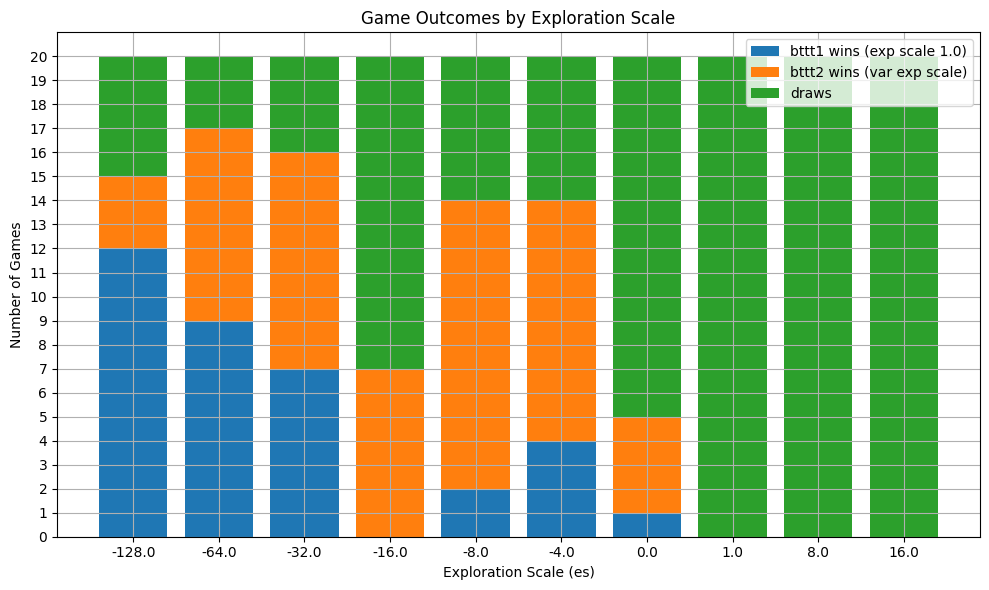

In [23]:
exploration_scale_df = pd.DataFrame(
    scores,
    index=[
        "(fixed exploration scale = 1.00)   bttt1 wins",
        "(variable exploration scale)       bttt2 wins",
        "draws",
    ],
)

display(exploration_scale_df)
nparr = exploration_scale_df.to_numpy()

bttt1_wins = nparr[0, :]
bttt2_wins = nparr[1, :]
draws = nparr[2,:]
x = np.arange(len(exp_scales))
# 2. Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
# 3. Create stacked bars
# First layer: bttt1 wins
ax.bar(x, bttt1_wins, label="bttt1 wins (exp scale 1.0)")
# Second layer: bttt2 wins (starts at the top of bttt1_wins)
ax.bar(x, bttt2_wins, bottom=bttt1_wins, label="bttt2 wins (var exp scale)")
# Third layer: draws (starts at the top of bttt1 + bttt2)
ax.bar(x, draws, bottom=np.array(bttt1_wins) + np.array(bttt2_wins), label="draws")
# 4. Format the chart
ax.set_ylabel("Number of Games")
ax.set_xlabel("Exploration Scale (es)")
ax.set_title("Game Outcomes by Exploration Scale")
ax.set_yticks(range(len(nr_of_games) + 1))
ax.set_xticks(x)
ax.set_xticklabels(exp_scales)
ax.legend()
plt.grid()
plt.tight_layout()
plt.show()